# Title

Importing relevant libraries

In [1]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns

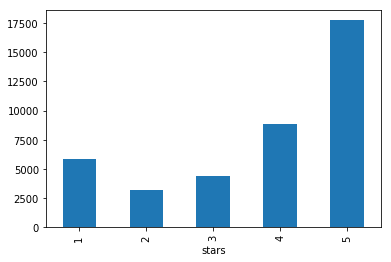

In [2]:
trainingAmount = 40000
testAmount = 10000

df_train = pd.read_json('training' + str(trainingAmount) +'.json', lines=True)
df_test = pd.read_json('test' + str(testAmount) +'.json', lines=True)

df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train.groupby("stars")['stars'].count().plot.bar()

## Cleaning the data

In [3]:
def clean(text):
    from nltk.stem import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    from nltk.tokenize import word_tokenize
    
     # Empty question
    if type(text) != str:
        return ''
    
    text = text.lower()
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    text = re.sub('[' + string.punctuation + ']', ' ', text)

    text = re.sub('im', "", text)

    
    #Tokenizing text for normalizing more easily
    tokenized_text = word_tokenize(text)
    
    
    
    #Removing stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    kept_words = ['he', 'she', 'they', 'we']
    for kw in kept_words:
        stopwords.remove(kw)
    
    tokenized_text = [w for w in tokenized_text if not w in stopwords] 
    
    
    #Removing numbers
    tokenized_text = [w for w in tokenized_text if w.isalpha()]
    
    
    #Putting tokens back together as a string
    text = ''
    for token in tokenized_text:
        text += token + ' '
        
    
    # Return a list of words
    return text

In [4]:
df_train['length'] = df_train['text'].apply(len)
df_test['length'] = df_test['text'].apply(len)

In [5]:
df_train.describe()

,stars,useful,funny,cool,length
count,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000
mean,3.736850,1.271325,0.445225,0.54120,584.396275
std,1.454048,2.784592,1.547840,1.92065,545.207561
min,1.000000,0.000000,0.000000,0.00000,1.000000
25%,3.000000,0.000000,0.000000,0.00000,233.000000
50%,4.000000,0.000000,0.000000,0.00000,416.000000
75%,5.000000,1.000000,0.000000,0.00000,741.000000
max,5.000000,91.000000,46.000000,86.00000,5000.000000


Cleaning the data

In [6]:
df_train['cleaned_text'] = df_train['text'].apply(clean)
df_test['cleaned_text'] = df_test['text'].apply(clean)

Saving all the necessary data in arrays

In [7]:
df_test

,text,stars,useful,funny,cool,length,cleaned_text
0,It is walking distance from the house. There i...,4,0,0,0,89,walking distance house shade back holes private
1,It has fast service and low prices. I recommen...,4,0,0,0,183,fast service low prices recommend deep dish li...
2,I came to this ob/gyn when I was pregnant last...,2,2,0,0,1168,came ob gyn pregnant last year dr tyre whole p...
3,Im only leaving 1 star out of courtesy. We had...,1,0,0,0,943,leaving star courtesy we reservations arrived ...
4,Couldn't be happier with the Venetian. The mal...,5,2,0,2,251,happier venetian mall casino lobby beautiful s...
5,"Really liked this place. Cool, laid atmosphere...",4,0,0,0,245,really liked place cool laid atmosphere super ...
6,We're spoiled in Vegas with the numerous ramen...,3,25,16,23,912,we spoiled vegas numerous ramen spots yagyu ra...
7,Best wings I've ever had? Probably not. But ...,4,5,0,2,939,best wings ever probably wide variety deliciou...
8,Amazing hotdogs. Best I've had in Las Vegas so...,5,1,0,1,186,amazing hotdogs best las vegas far delicious f...
9,I really wanted to like this place. Called a...,2,0,0,0,1321,really wanted like place called ahead party se...


In [8]:
train = df_train['cleaned_text'].values
test = df_test['cleaned_text'].values
trainStars = df_train['stars'].values
testStars = df_test['stars'].values

## BOW model with Naïve Bayes Classifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

In [10]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
testStars_predicted = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

60.78 %


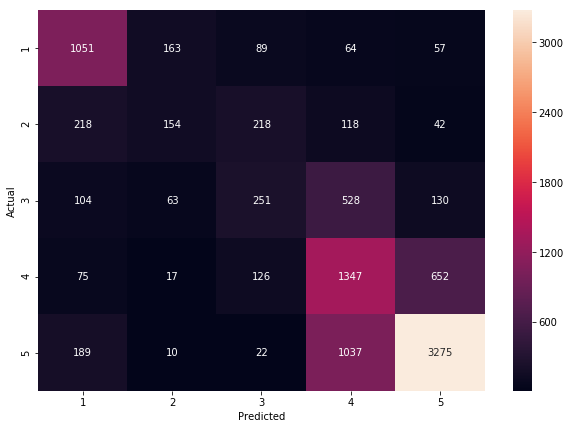

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
print(classification_report(testStars, testStars_predicted, digits=5))

              precision    recall  f1-score   support

           1    0.64203   0.73806   0.68670      1424
           2    0.37838   0.20533   0.26621       750
           3    0.35552   0.23327   0.28171      1076
           4    0.43536   0.60758   0.50725      2217
           5    0.78802   0.72248   0.75383      4533

   micro avg    0.60780   0.60780   0.60780     10000
   macro avg    0.51986   0.50134   0.49914     10000
weighted avg    0.61178   0.60780   0.60223     10000



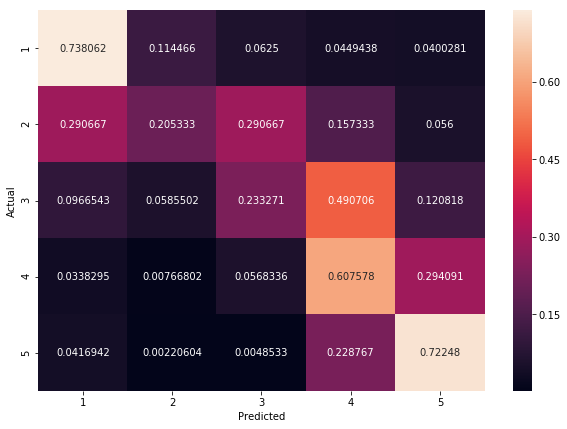

In [15]:
confusion_matrix_proportions = []
for n in range(confusion_matrix.shape[0]):
    confusion_matrix_proportions.append(confusion_matrix[n,:]/df_test.groupby('stars').count().at[n+1, 'text'])
    
confusion_matrix_proportions = num.array(confusion_matrix_proportions)

df_cm = pd.DataFrame(confusion_matrix_proportions, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
import collections
distance = num.abs(testStars - testStars_predicted)
collections.Counter(distance)

Counter({1: 3005, 0: 6078, 2: 480, 4: 246, 3: 191})

## Word2Vec model
Tokenizing the words

In [17]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

train_tokenized = [word_tokenize(token) for token in train]
test_tokenized = [word_tokenize(token) for token in test]
word2vec = Word2Vec(train_tokenized, min_count=10)

word2vec.init_sims(replace=True)

In [18]:
def sent2vec(reviewTok):
    vecSize = len(word2vec.wv[reviewTok[0][0]])
    reviewVec = []
    for sentence in reviewTok:
        vectorSum = num.zeros(vecSize)
        empty = True
        for token in sentence:
            if token in word2vec.wv.vocab:
                vectorSum += word2vec.wv[token]
                empty = False
        if not empty:
            vectorSum = vectorSum / num.sqrt((vectorSum ** 2).sum())
        reviewVec.append(vectorSum)
    return num.array(reviewVec)

In [19]:
train_vectors = sent2vec(train_tokenized)
test_vectors = sent2vec(test_tokenized)

### XGBoost classifier

In [21]:
from xgboost import XGBClassifier
xgbclassifier = XGBClassifier()
xgbclassifier.fit(train_vectors, trainStars)
testStars_predicted = xgbclassifier.predict(test_vectors)
print(xgbclassifier.score(test_vectors, testStars)*100, '%')

62.529999999999994 %


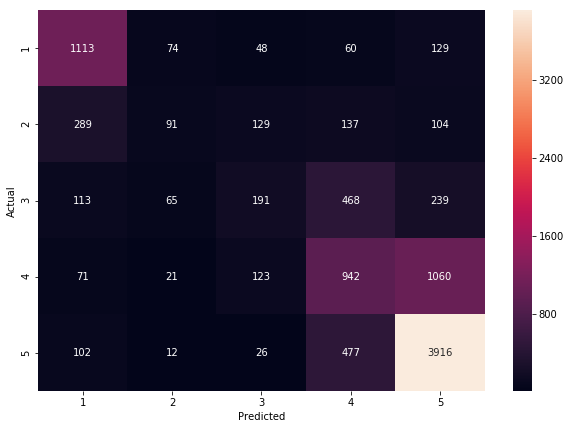

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Support Vector  Machine classifier

In [24]:
from sklearn.svm import SVC
svc = SVC(gamma='auto', C=2)
svc.fit(train_vectors, trainStars)
testStars_predicted = xgbclassifier.predict(test_vectors)
print(svc.score(test_vectors, testStars)*100, '%')

62.78 %


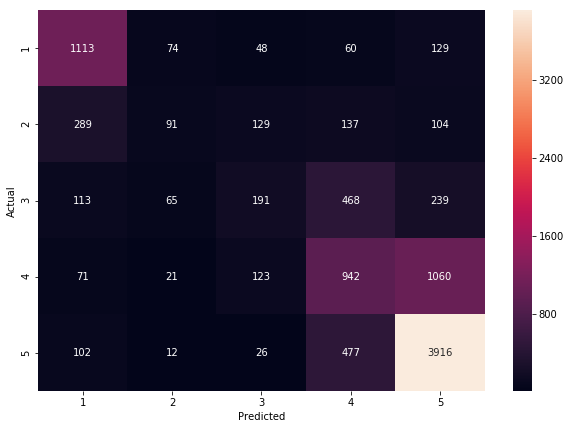

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

***

### Looking for relation between text length and rating
Tests with charts

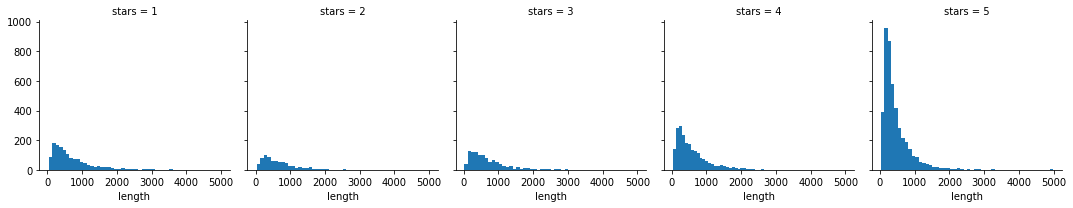

In [26]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

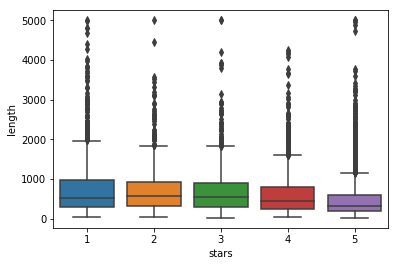

In [27]:
sns.boxplot(x='stars', y='length', data=df_test)

In [28]:
df_test.describe()

,stars,useful,funny,cool,length
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.768500,1.255300,0.426900,0.543700,587.212100
std,1.445378,2.864567,1.538601,2.083729,555.143887
min,1.000000,0.000000,0.000000,0.000000,16.000000
25%,3.000000,0.000000,0.000000,0.000000,231.000000
50%,4.000000,0.000000,0.000000,0.000000,410.000000
75%,5.000000,1.000000,0.000000,0.000000,748.000000
max,5.000000,101.000000,40.000000,94.000000,4998.000000


In [35]:
starProp_train = df_train.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1).drop('cleaned_text', axis=1)
starProp_train['percentage'] = starProp_train['text'] / df_train.shape[0] * 100
starProp_train


,text,percentage
stars,,
1,5821,14.5525
2,3205,8.0125
3,4391,10.9775
4,8845,22.1125
5,17738,44.3450


In [36]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1).drop('cleaned_text', axis=1)
starProp_test['percentage'] = starProp_test['text'] / df_test.shape[0] * 100
starProp_test


,text,percentage
stars,,
1,1424,14.24
2,750,7.50
3,1076,10.76
4,2217,22.17
5,4533,45.33


Training and test set have same proportions! :-)

ideas:
- make a numbers token <NUMBER>
- stem the words
- remove stopwords
- create a personal noun token <PERSONALNOUN>